In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import yfinance as yf
import datetime

# import from utils.ipynb
import ipynb.fs.full.utils as utils

# 1. Load raw input
## Hardcoded block

In [2]:
evaluate_last_X_years = False
X=10
currency_pair = 'USD=X'
numbers_in_currency = 'USD'
share_name = 'SBSW'

# 1.1 Calculate Share numbers from total distributed dividend (CFS) and dividend amount

# 1.2. Raw input statement data

In [21]:
route = f"../csv_files/{share_name}_data.csv"
data = pd.read_csv(route, sep=';', parse_dates=['date'])
# replace -, extend missing 0-s, fix datatype
data = utils.replace_format_input(data)

## (OPTIONAL) Time Filtering - Last 7 years daat

In [22]:
if evaluate_last_X_years:
    data = data[data['date'] > datetime.datetime.today() - datetime.timedelta(days=X*366+93)]
    data = data.reset_index(drop=True)

data.head()

,date,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,curr_assets,goodwill,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,shares
0,2012-06-30,1135,-675,460,319,143,61,123,327,0,...,2370,2457,0,0,2784,116,3568,293,-189,572
1,2012-12-31,886,-652,233,45,34,64,106,204,0,...,2299,2001,259,0,2500,233,3427,32,-190,572
2,2013-06-30,1007,-644,363,32,206,89,34,334,0,...,2066,225,49,0,336,345,1259,373,-157,572
3,2013-12-31,1007,-608,399,145,144,94,18,262,0,...,1940,200,48,0,347,144,1022,295,-145,748
4,2014-06-30,920,-594,327,50,114,75,27,223,69,...,2530,280,52,0,415,120,1174,234,-126,792


## Calculate date when quaterly reports could be available

In [23]:
data = utils.calculate_real_date(data)

# 2. Filter out unnecesary columns

In [24]:
data = utils.filter_raw_data(data)
data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,intangible_assets,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex
18,2021-06-30,2021-07-21,2979,6182,-3570,2612,1740,1829,544,2063,...,0,10262,1040,459,0,1637,745,4424,913,-384
19,2021-12-31,2022-02-11,2877,5461,-3821,1640,544,1900,465,1573,...,0,9598,951,7,0,1290,1267,4496,1267,-477
20,2022-06-30,2022-07-21,2831,4570,-3263,1307,803,1673,437,1658,...,0,9736,883,7,0,1152,1275,4249,285,-399
21,2022-12-31,2023-02-11,2831,3878,-2945,933,359,1531,440,1549,...,0,9783,919,7,0,1187,1327,4441,664,-572
22,2023-06-30,2023-07-21,2831,3326,-2728,598,427,1176,425,1364,...,0,9569,816,7,0,957,1336,4260,272,-596


## Pull historical average USD national currency rates and add to the dataframe

In [25]:
if currency_pair != 'USD=X':
    data['usd_nat_currency'] = utils.daily_price(
        ticker=currency_pair,
        end=data['date'],
        days_earlier=90
        )
else:
    data['usd_nat_currency'] = [1 for x in range(len(data))]

# drop rows, when USD rates wasn't available
data = data[data['usd_nat_currency'].notna()]

data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
18,2021-06-30,2021-07-21,2979,6182,-3570,2612,1740,1829,544,2063,...,10262,1040,459,0,1637,745,4424,913,-384,1
19,2021-12-31,2022-02-11,2877,5461,-3821,1640,544,1900,465,1573,...,9598,951,7,0,1290,1267,4496,1267,-477,1
20,2022-06-30,2022-07-21,2831,4570,-3263,1307,803,1673,437,1658,...,9736,883,7,0,1152,1275,4249,285,-399,1
21,2022-12-31,2023-02-11,2831,3878,-2945,933,359,1531,440,1549,...,9783,919,7,0,1187,1327,4441,664,-572,1
22,2023-06-30,2023-07-21,2831,3326,-2728,598,427,1176,425,1364,...,9569,816,7,0,957,1336,4260,272,-596,1


## Convert USD values related to IS, BS, CFS to national currency

In [26]:
# convert columns into national currency if necessary
if numbers_in_currency == 'USD':
    data_nat_curr = utils.convert_national_currency(input_data=data, currency=data)
else:
    data_nat_curr = data.copy()
data_nat_curr.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
18,2021-06-30,2021-07-21,2979,6182.0,-3570.0,2612.0,1740.0,1829.0,544.0,2063.0,...,10262.0,1040.0,459.0,0.0,1637.0,745.0,4424.0,913.0,-384.0,1
19,2021-12-31,2022-02-11,2877,5461.0,-3821.0,1640.0,544.0,1900.0,465.0,1573.0,...,9598.0,951.0,7.0,0.0,1290.0,1267.0,4496.0,1267.0,-477.0,1
20,2022-06-30,2022-07-21,2831,4570.0,-3263.0,1307.0,803.0,1673.0,437.0,1658.0,...,9736.0,883.0,7.0,0.0,1152.0,1275.0,4249.0,285.0,-399.0,1
21,2022-12-31,2023-02-11,2831,3878.0,-2945.0,933.0,359.0,1531.0,440.0,1549.0,...,9783.0,919.0,7.0,0.0,1187.0,1327.0,4441.0,664.0,-572.0,1
22,2023-06-30,2023-07-21,2831,3326.0,-2728.0,598.0,427.0,1176.0,425.0,1364.0,...,9569.0,816.0,7.0,0.0,957.0,1336.0,4260.0,272.0,-596.0,1


# 3. Calculate input to Value Raios (eps, bv per share, fcf)
## filter out unwanted columns

In [27]:
filtered_nat_curr = utils.calculate_input_value_ratios(data_nat_curr, report='half-year')

## Calculate input values to value ratios

In [28]:
ratios_nat_curr = utils.ratios_input_filter(filtered_nat_curr)

## Calculate performance parameters (current ratio, ROA, ROE, margins, D/E)

In [29]:
ratios_nat_curr = utils.evaluate_performance(input=filtered_nat_curr, output=ratios_nat_curr, report='half-year')

# 4. Pull historical share prices and merge with sattement data

In [30]:
# pull weekly share prices and merge with the value ratios
merged_nat_curr = utils.add_share_prices_to_value_ratios(share_name, data, ratios_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,equity_ratio,debt_ratio,acc_rec_ratio,acc_pay_ratio,cash_turnover,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe
0,2013-02-11,4.847410,2012-12-31,886.0,0.157343,-1.972028,572,444.0,0.776224,34.0,...,-0.490648,1.490648,27.6875,0.651674,52.117647,12.301887,0.26298,0.05079,0.039147,-0.079787
1,2013-02-18,3.891209,2012-12-31,886.0,0.157343,-1.972028,572,444.0,0.776224,34.0,...,-0.490648,1.490648,27.6875,0.651674,52.117647,12.301887,0.26298,0.05079,0.039147,-0.079787
2,2013-02-25,3.891209,2012-12-31,886.0,0.157343,-1.972028,572,444.0,0.776224,34.0,...,-0.490648,1.490648,27.6875,0.651674,52.117647,12.301887,0.26298,0.05079,0.039147,-0.079787
3,2013-03-04,4.196661,2012-12-31,886.0,0.157343,-1.972028,572,444.0,0.776224,34.0,...,-0.490648,1.490648,27.6875,0.651674,52.117647,12.301887,0.26298,0.05079,0.039147,-0.079787
4,2013-03-11,3.957611,2012-12-31,886.0,0.157343,-1.972028,572,444.0,0.776224,34.0,...,-0.490648,1.490648,27.6875,0.651674,52.117647,12.301887,0.26298,0.05079,0.039147,-0.079787


# Calculate price ratios (P/E, P/B, P/S, P/FCF)

In [31]:
merged_nat_curr = utils.price_ratios(merged_nat_curr, report='half-year')
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,pfcf_ratio
0,2013-02-11,4.847410,2012-12-31,886.0,0.157343,-1.972028,572,444.0,0.776224,34.0,...,12.301887,0.26298,0.05079,0.039147,-0.079787,30.807985,-2.458084,1.564740,3.479525,6.244862
1,2013-02-18,3.891209,2012-12-31,886.0,0.157343,-1.972028,572,444.0,0.776224,34.0,...,12.301887,0.26298,0.05079,0.039147,-0.079787,24.730796,-1.973202,1.256079,3.170864,5.012999
2,2013-02-25,3.891209,2012-12-31,886.0,0.157343,-1.972028,572,444.0,0.776224,34.0,...,12.301887,0.26298,0.05079,0.039147,-0.079787,24.730796,-1.973202,1.256079,3.170864,5.012999
3,2013-03-04,4.196661,2012-12-31,886.0,0.157343,-1.972028,572,444.0,0.776224,34.0,...,12.301887,0.26298,0.05079,0.039147,-0.079787,26.672115,-2.128094,1.354679,3.269464,5.406510
4,2013-03-11,3.957611,2012-12-31,886.0,0.157343,-1.972028,572,444.0,0.776224,34.0,...,12.301887,0.26298,0.05079,0.039147,-0.079787,25.152819,-2.006874,1.277513,3.192299,5.098544


# Calculate Dividend yield and currency-share price correlation

In [32]:
# get daily historical USD-national currency rates
usd_nat_curr = utils.get_historical_currency_rate(currency_pair, merged_nat_curr)

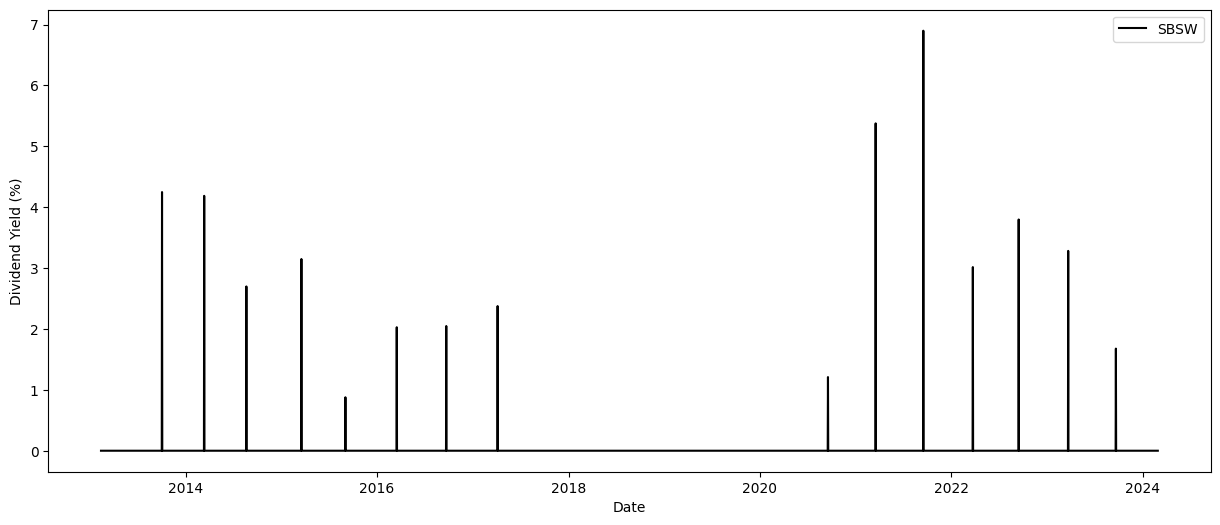

In [33]:
# get share prices and dividend yield data
ticker_all_price = utils.get_historical_share_dividend(share_name, merged_nat_curr)

currency_rate   NaN
share_price     NaN
Name: share_price, dtype: float64


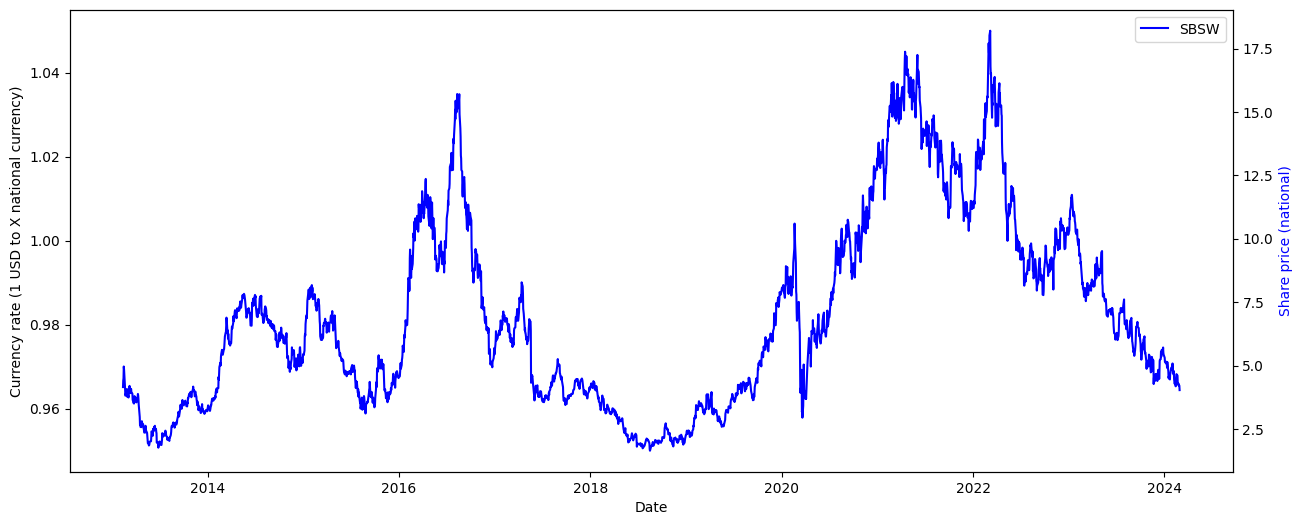

In [34]:
# Pearson's correlation coefficient between share price and USD - national currency rate
utils.get_currency_share_price_correlation(share_name, usd_nat_curr, ticker_all_price)

# Share price and value ratios

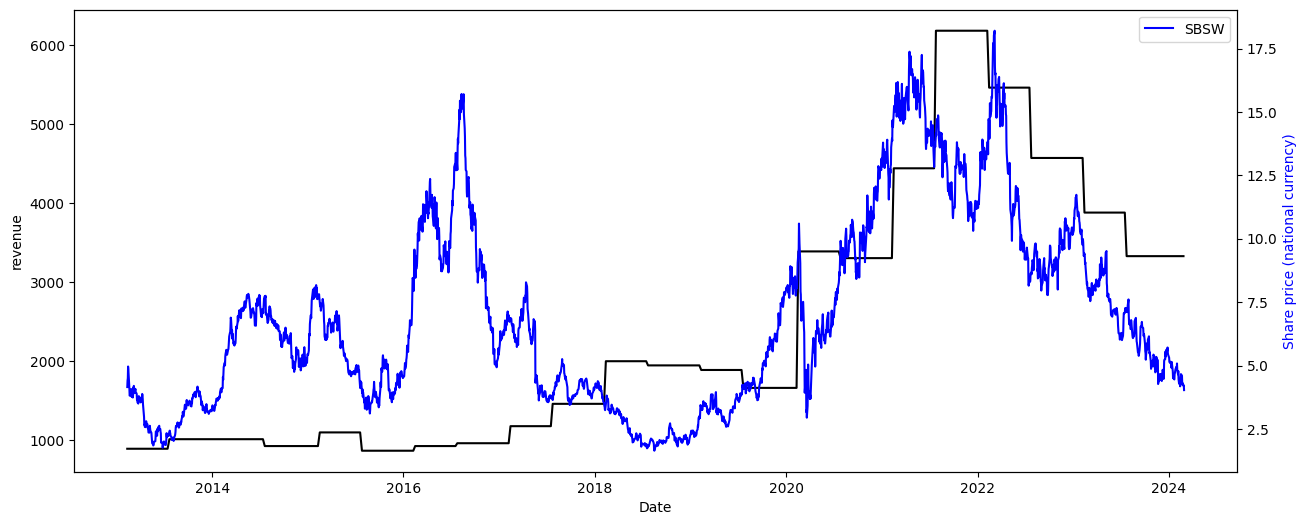

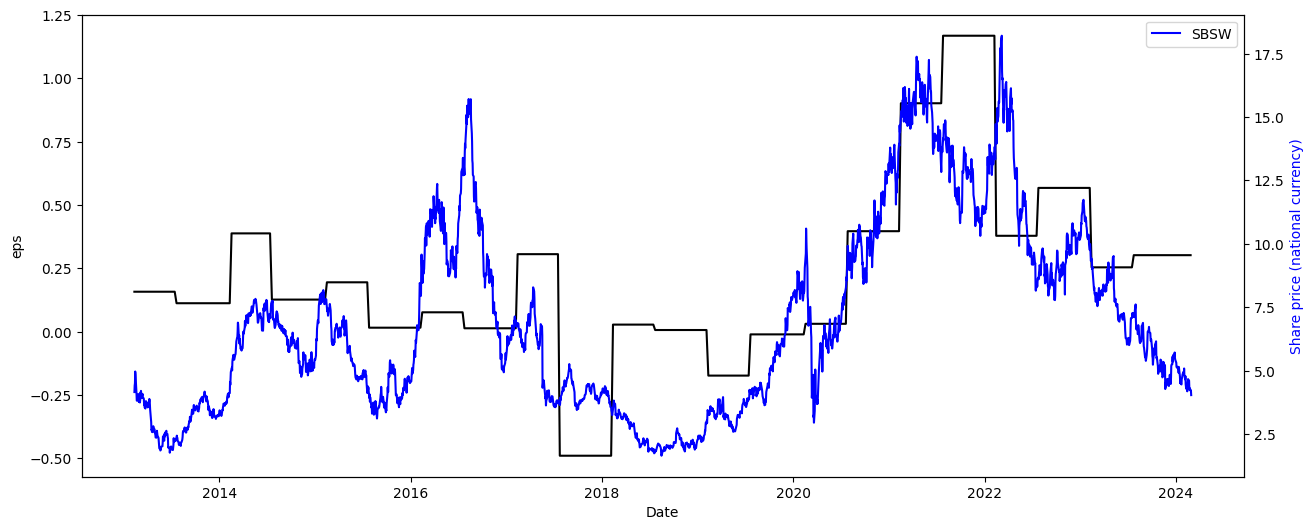

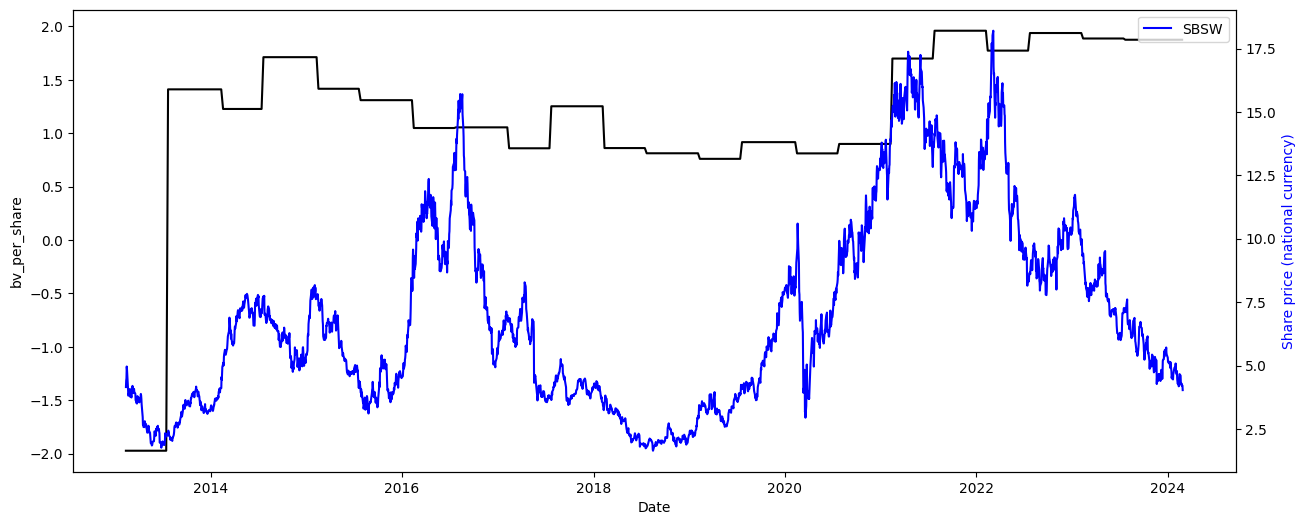

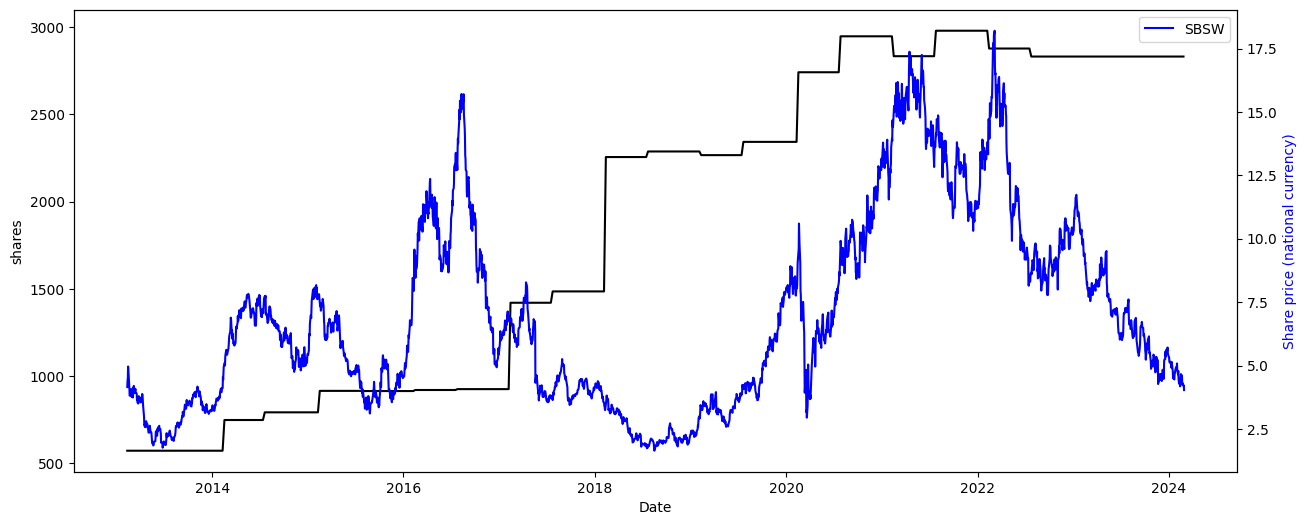

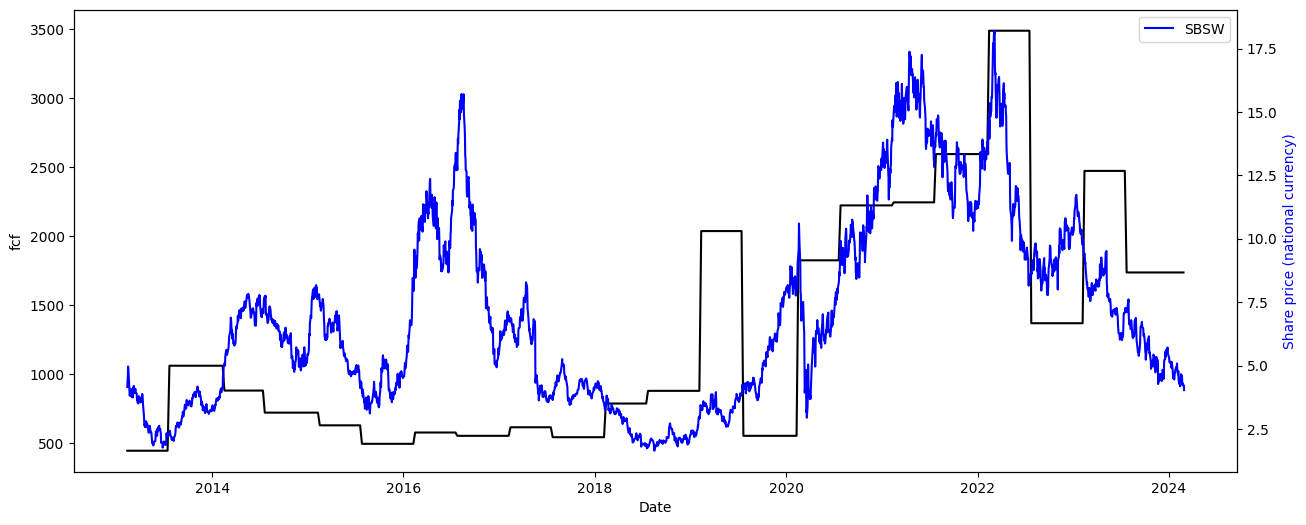

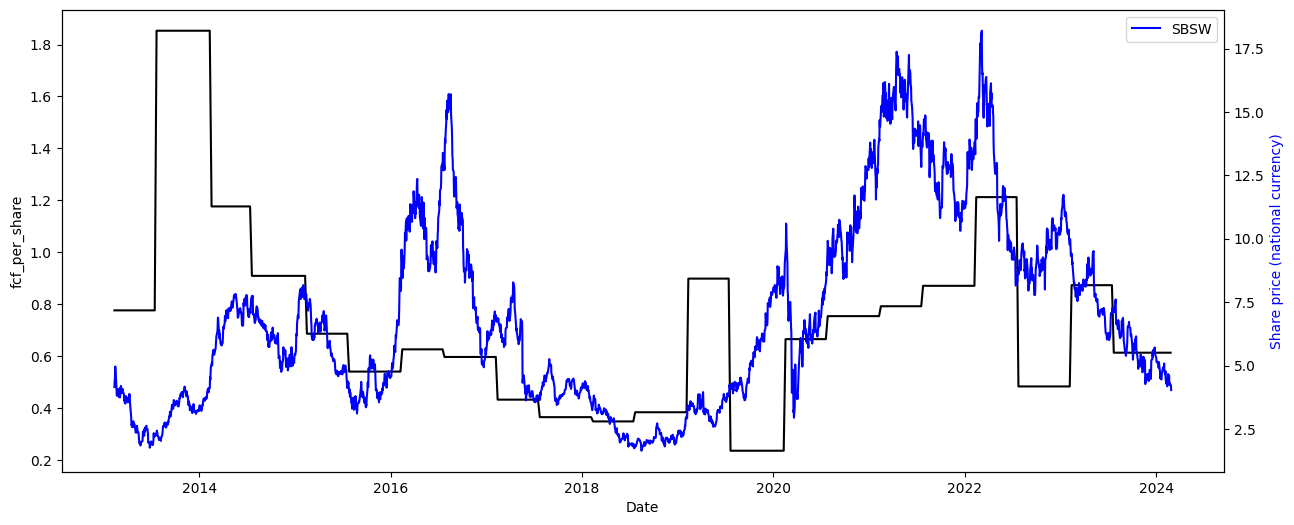

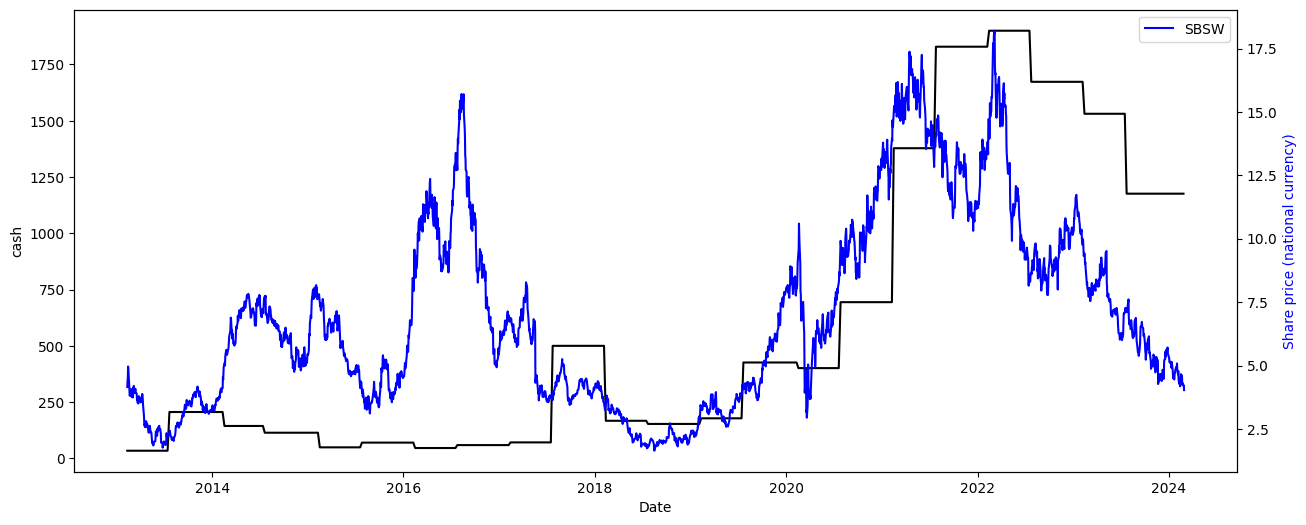

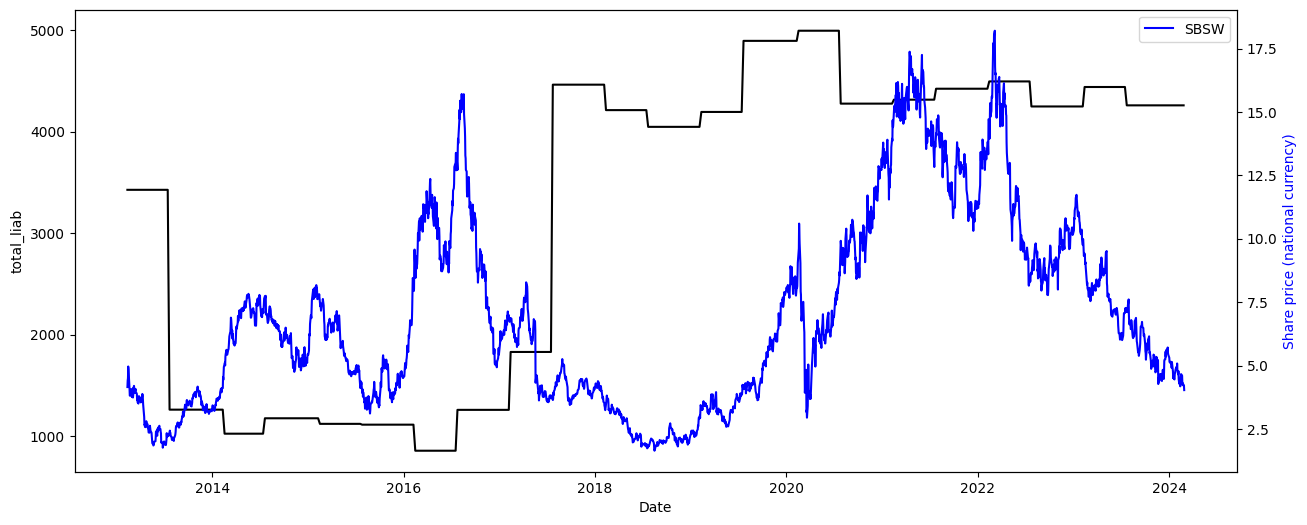

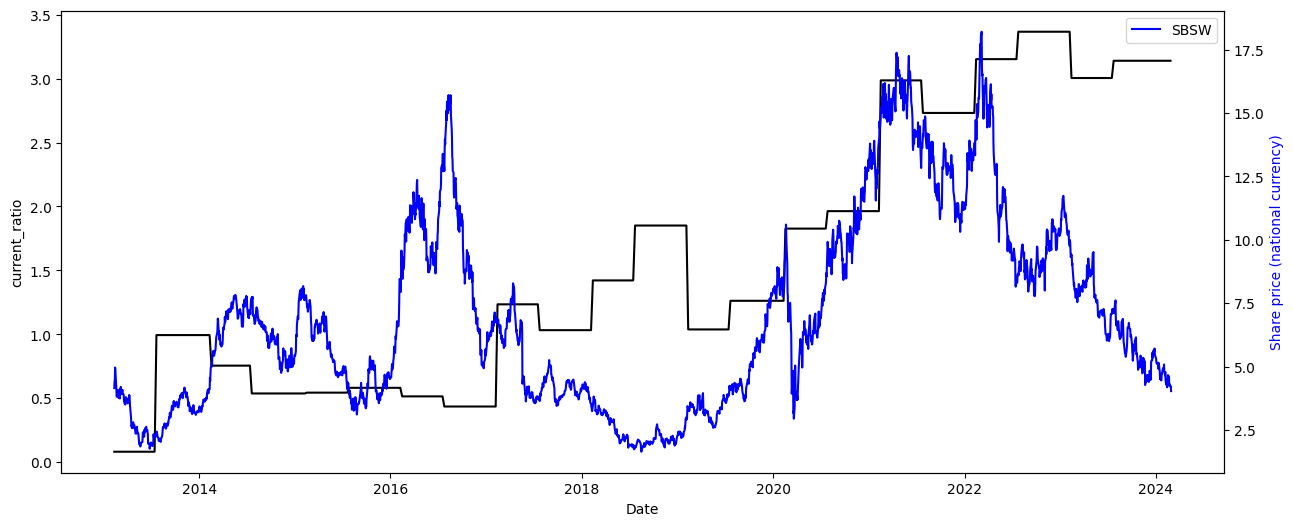

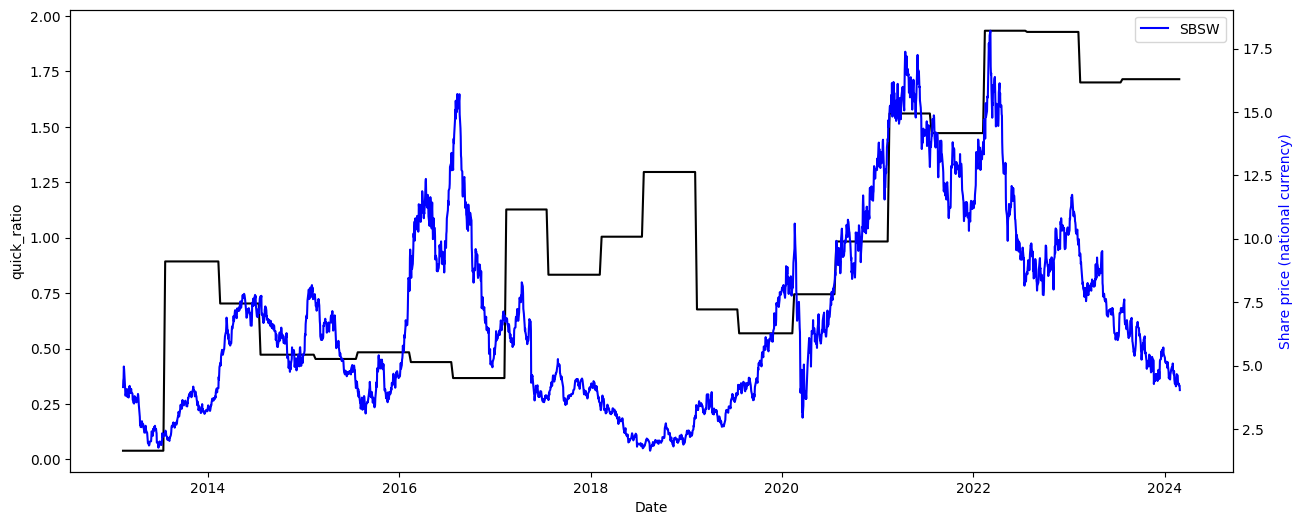

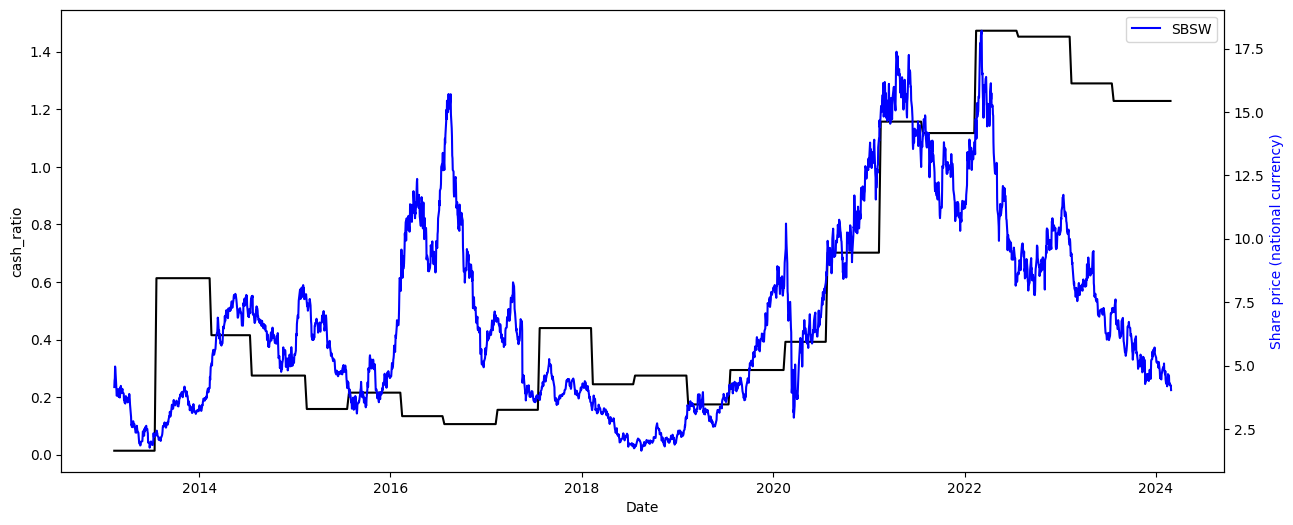

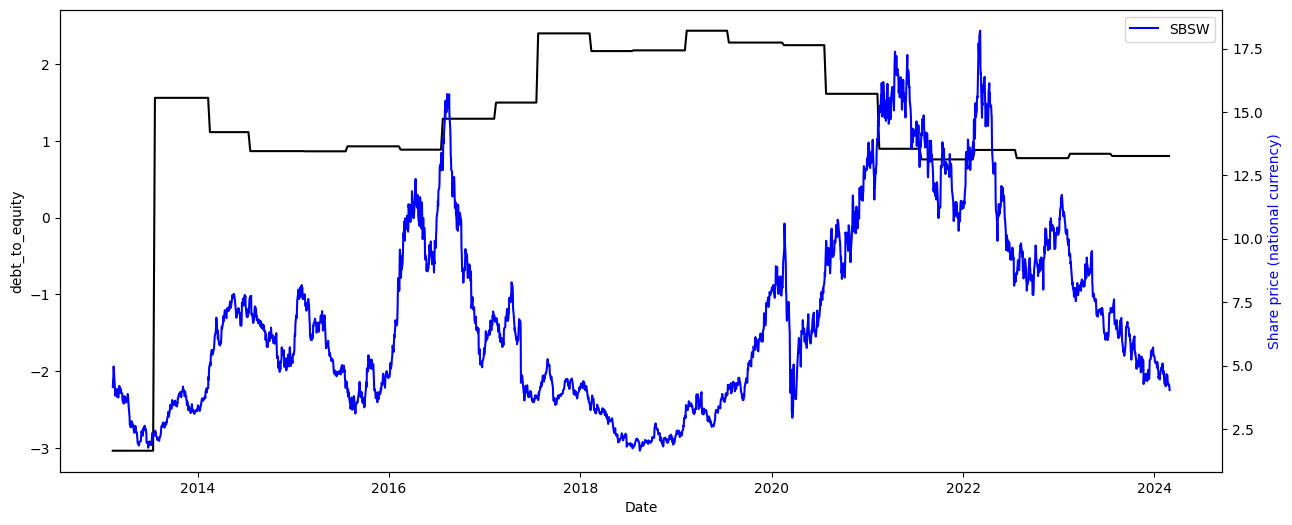

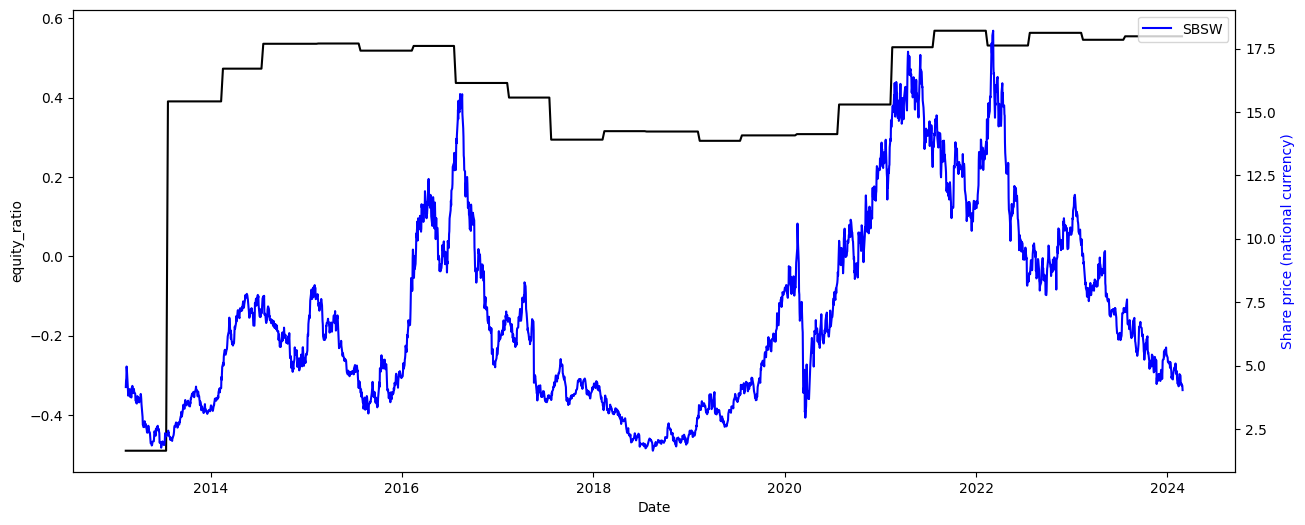

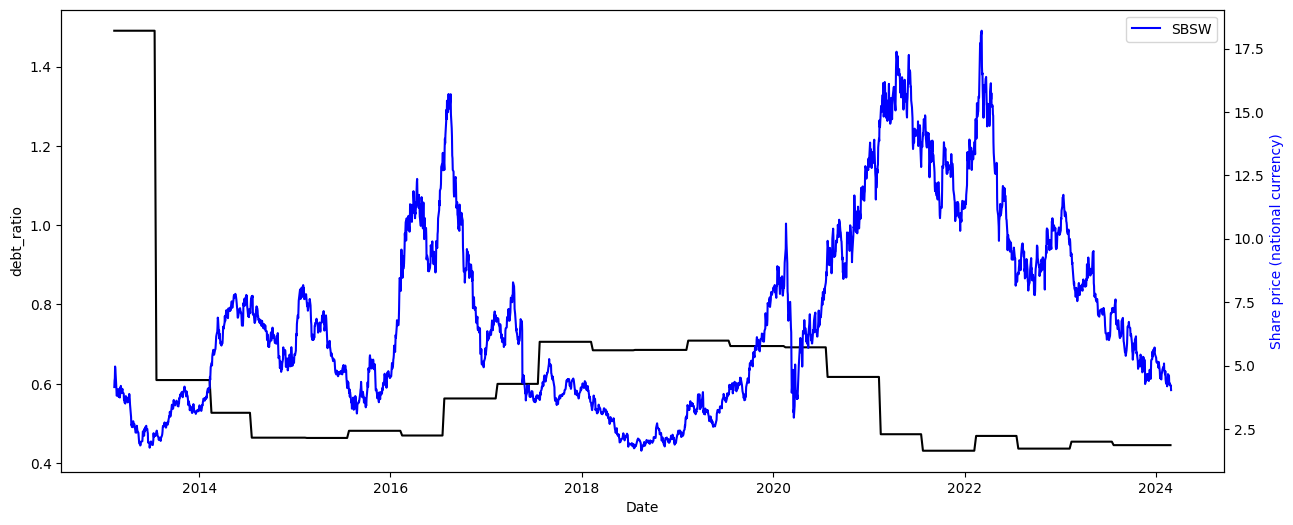

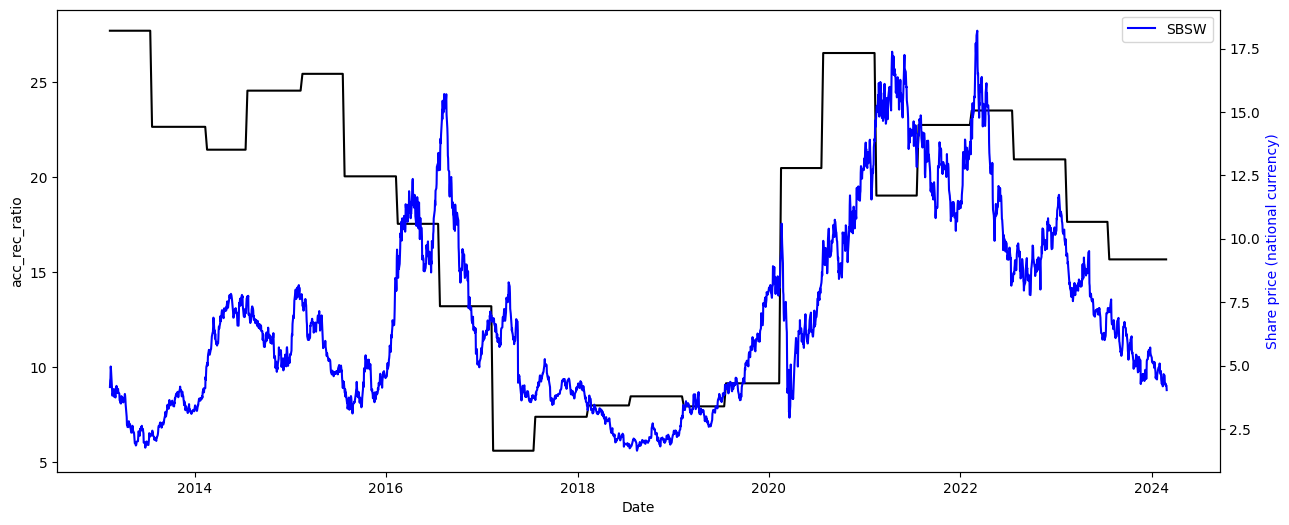

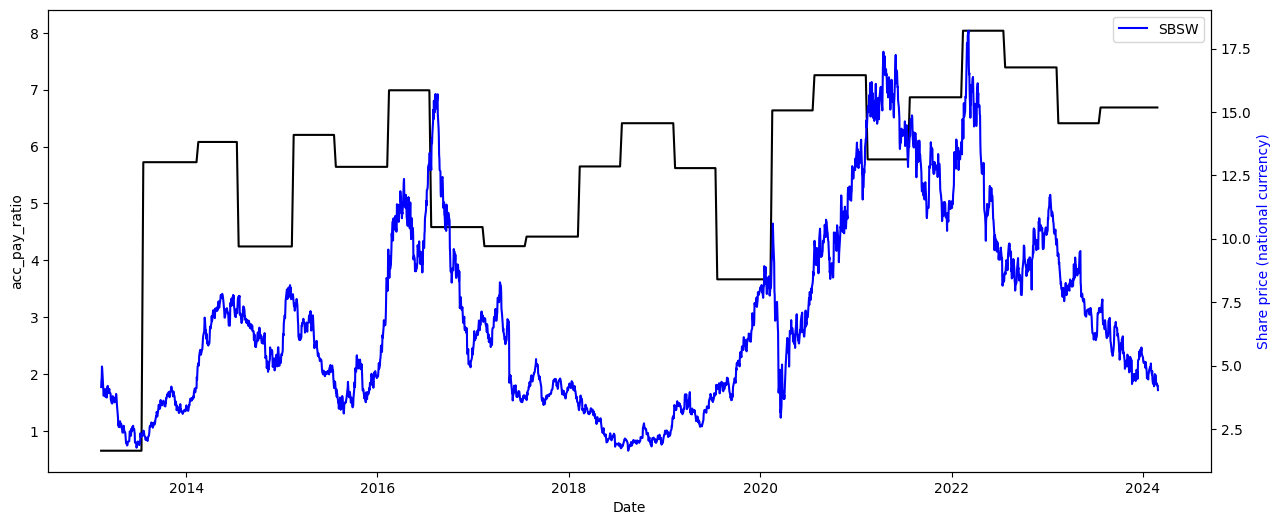

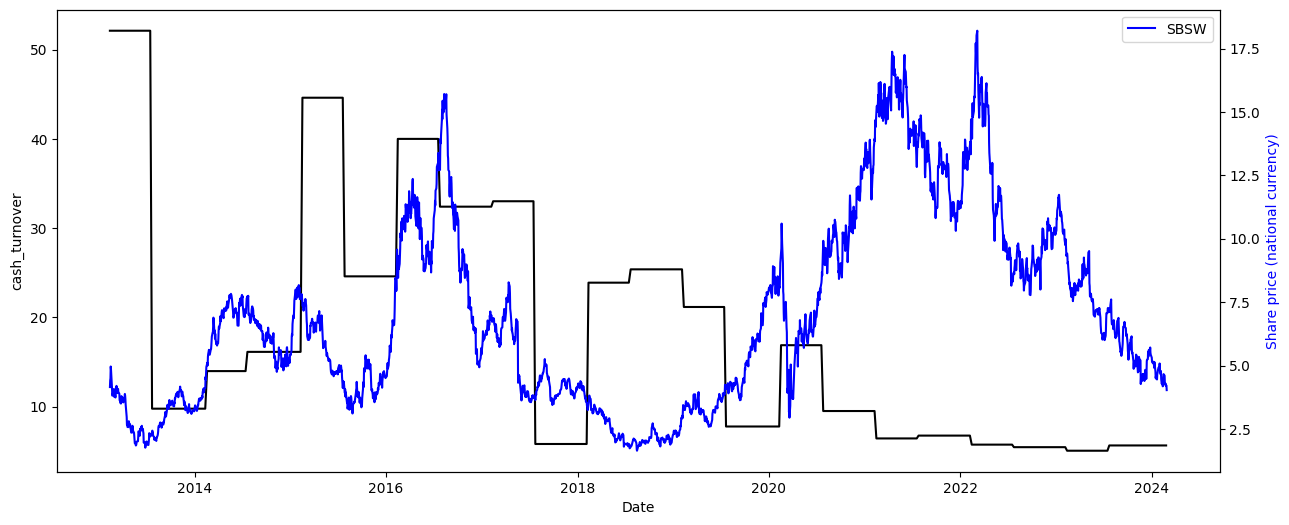

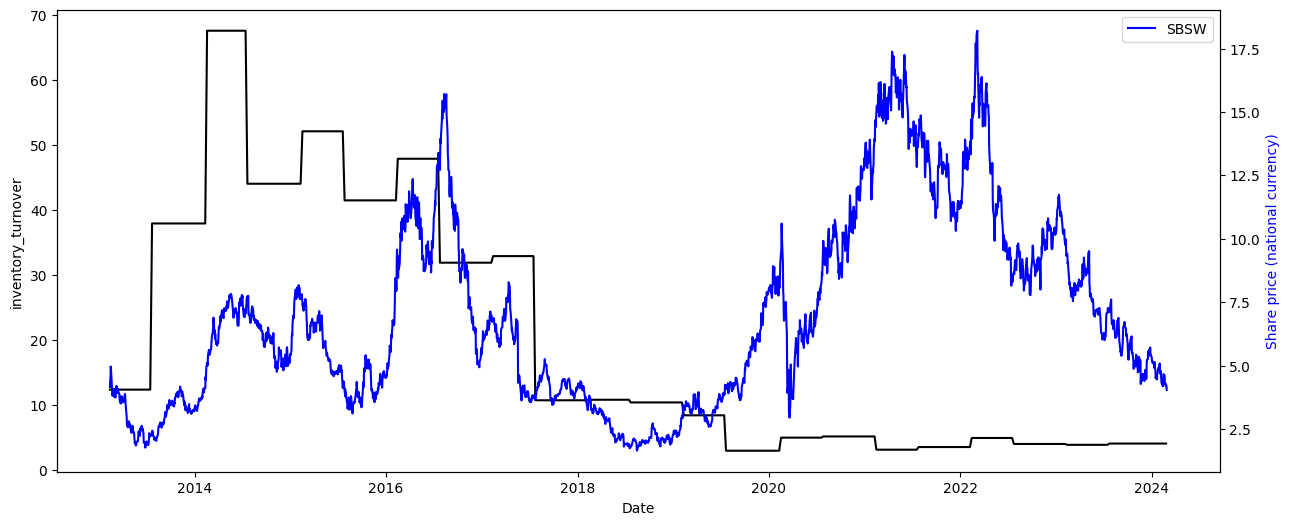

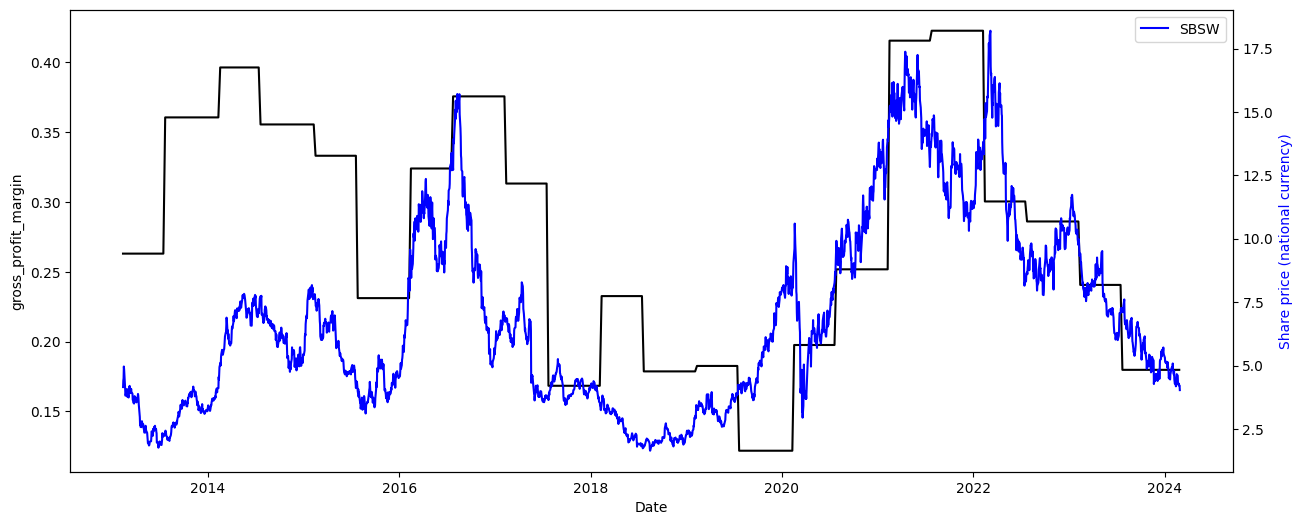

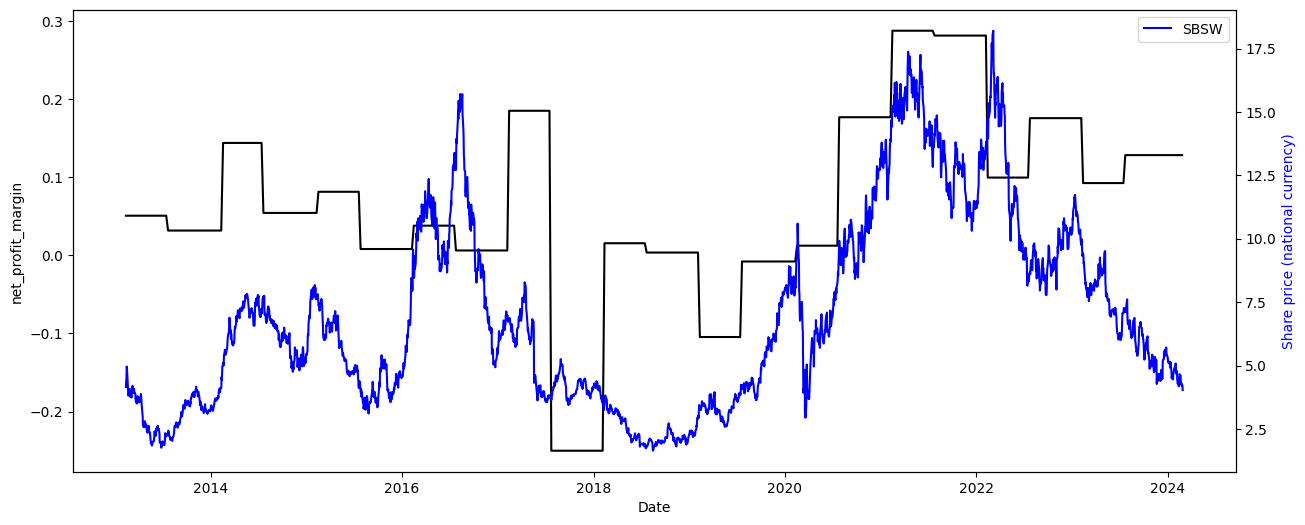

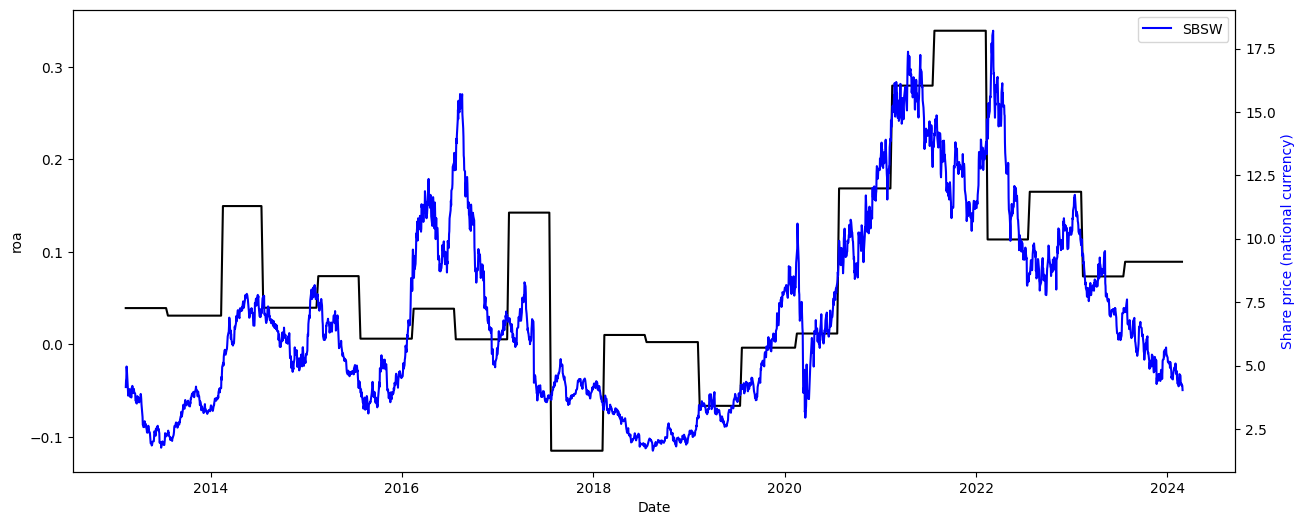

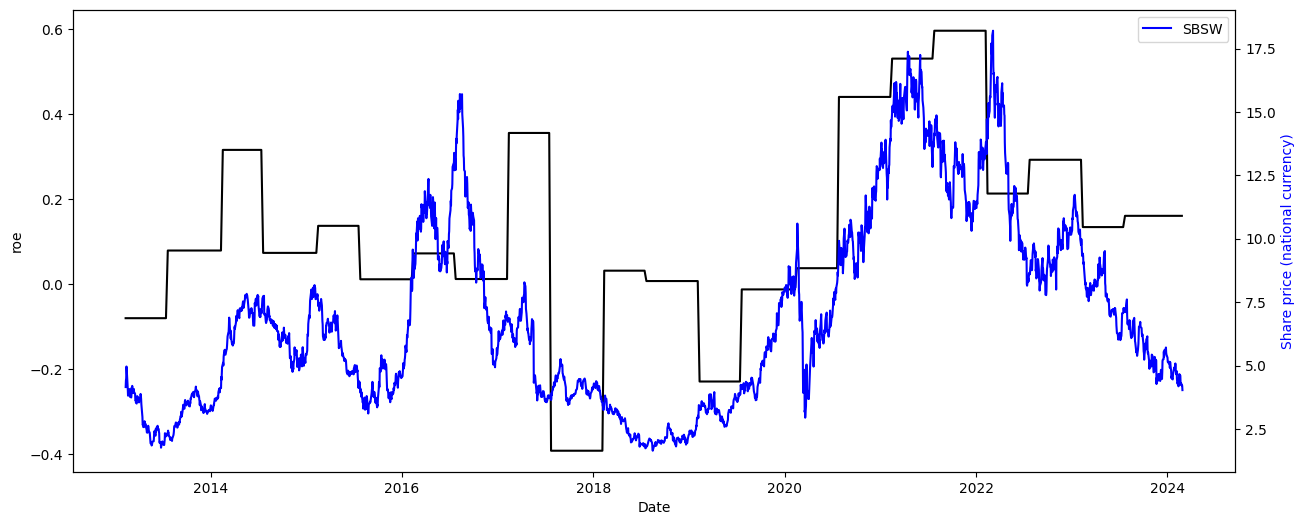

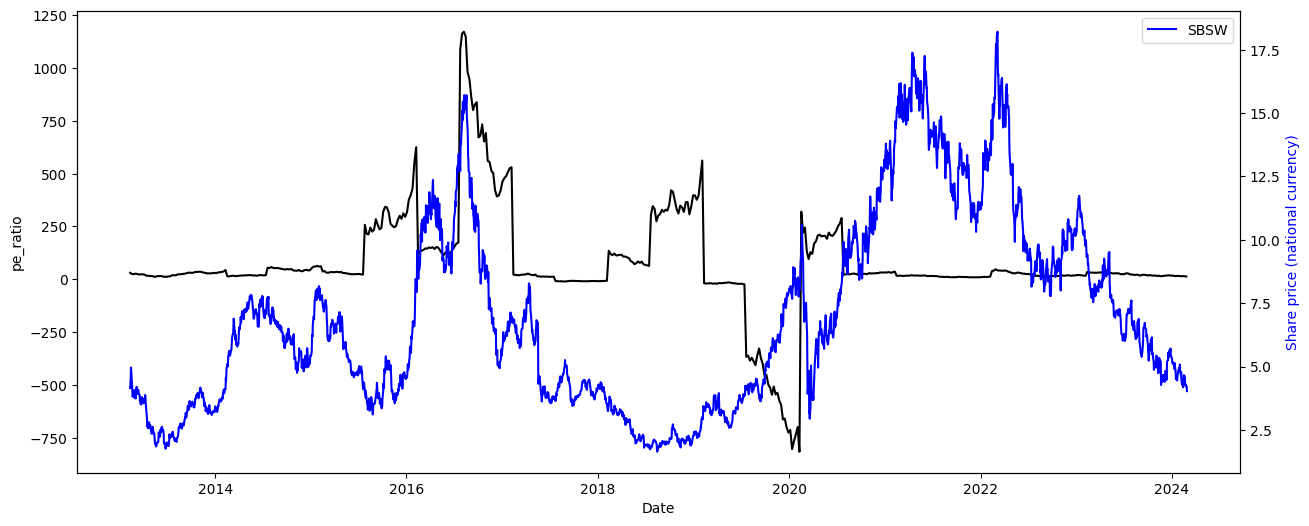

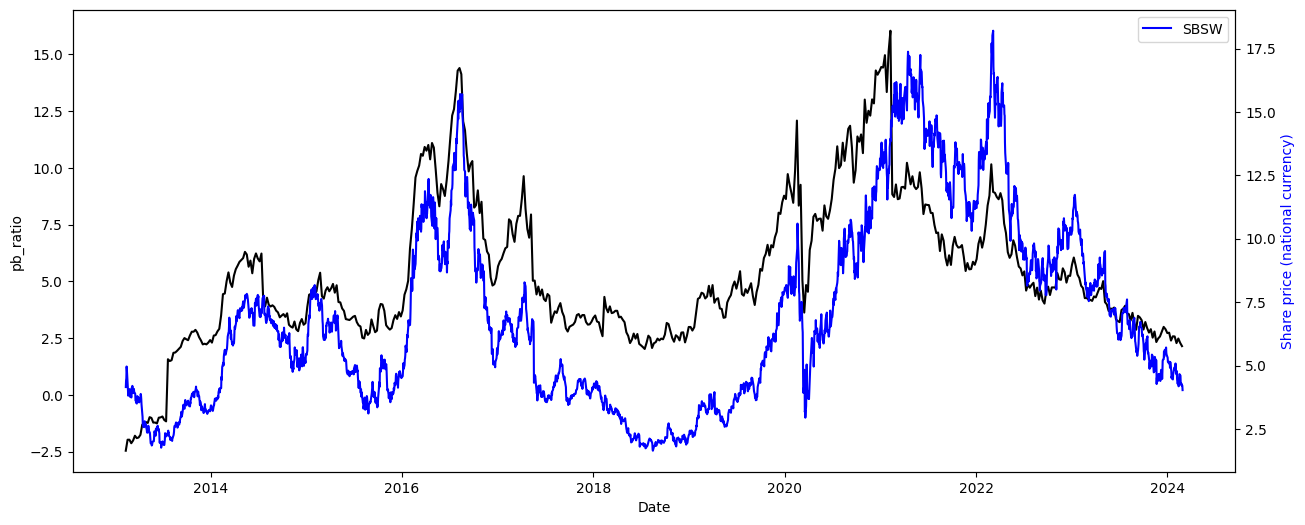

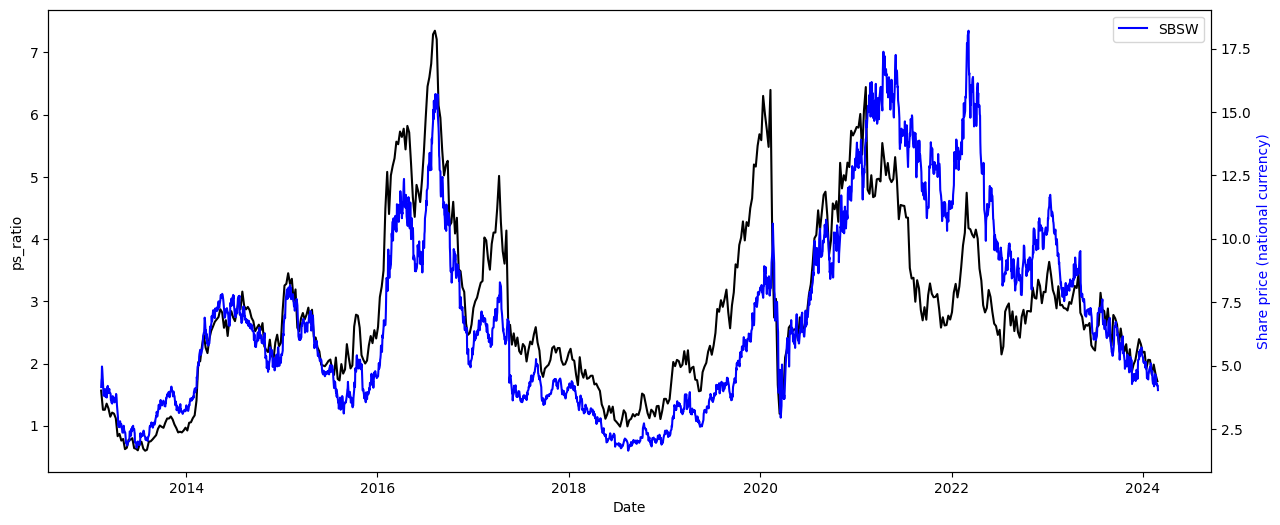

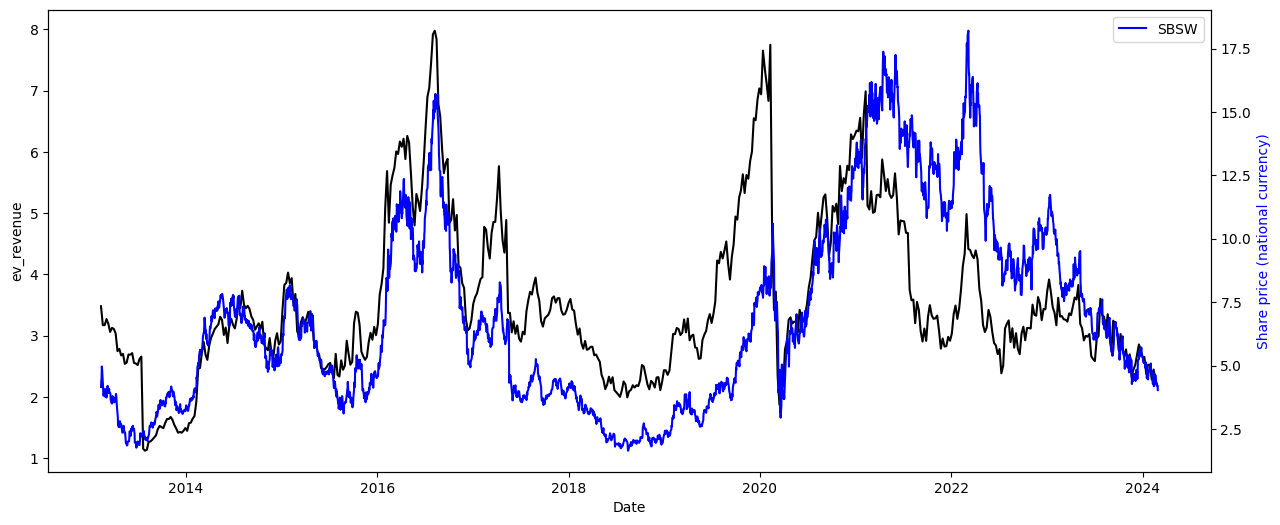

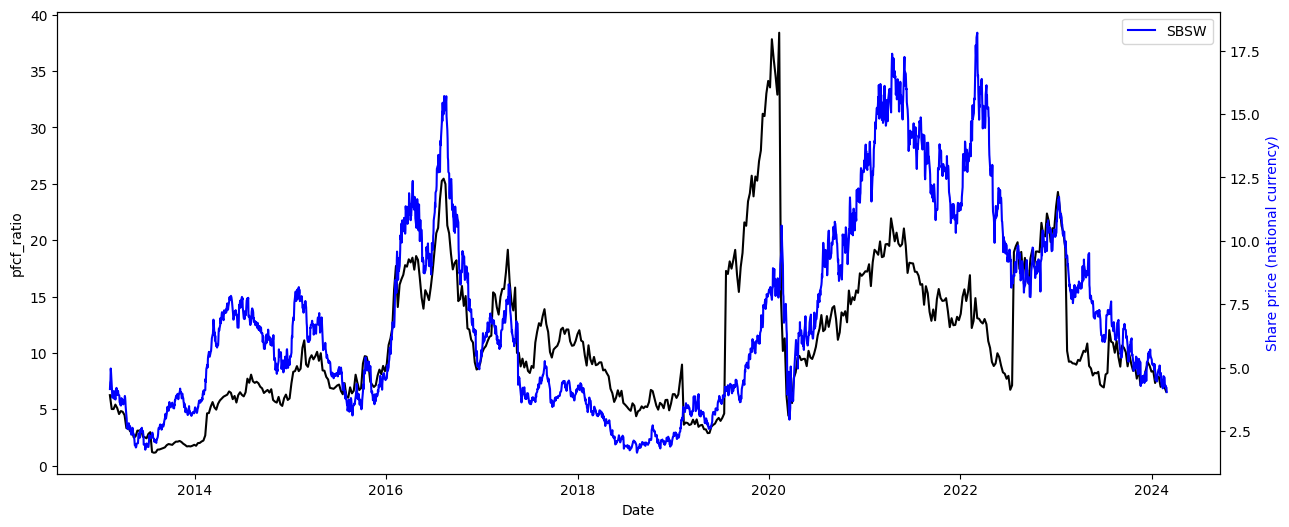

In [35]:
for column in merged_nat_curr.columns[3:]:
    fig, ax1 = plt.subplots(figsize=(15, 6))

    ax2 = ax1.twinx()
    ax1.plot(merged_nat_curr['real_date'], merged_nat_curr[column], color='k', label=merged_nat_curr)
    ax2.plot(ticker_all_price.index, ticker_all_price['Close'], color='b', label=share_name)

    ax1.set_xlabel('Date')
    ax1.set_ylabel(column, color='k')
    ax2.set_ylabel('Share price (national currency)', color='b')

    plt.legend()
    plt.show()

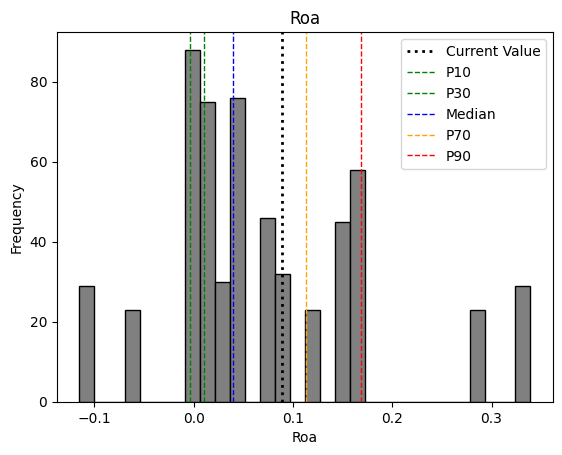

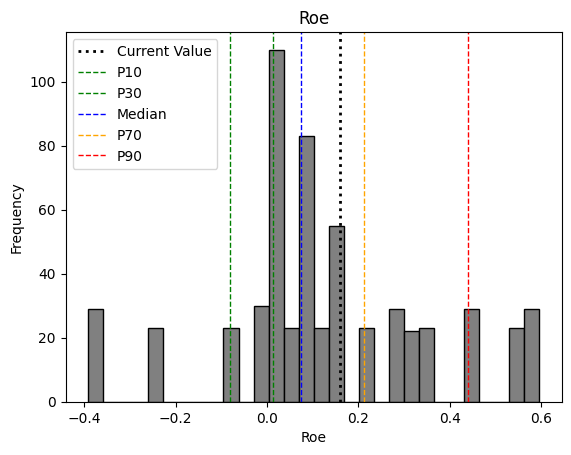

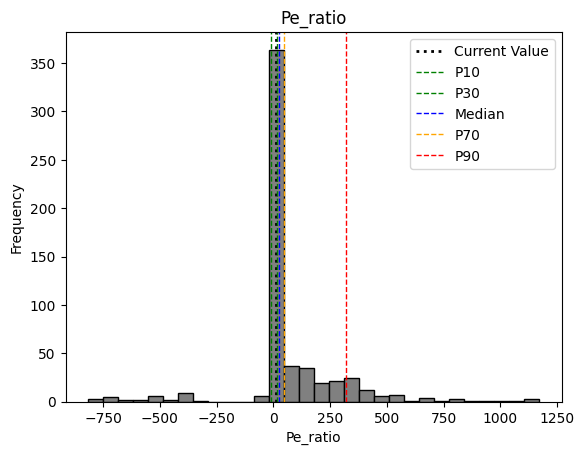

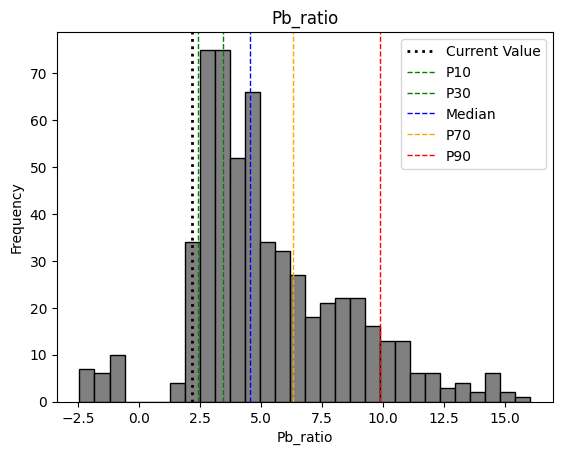

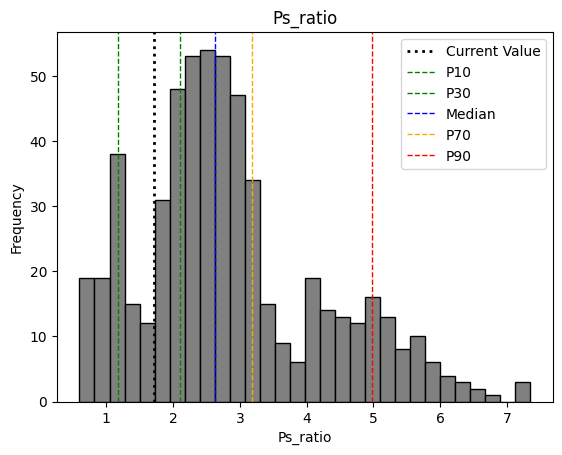

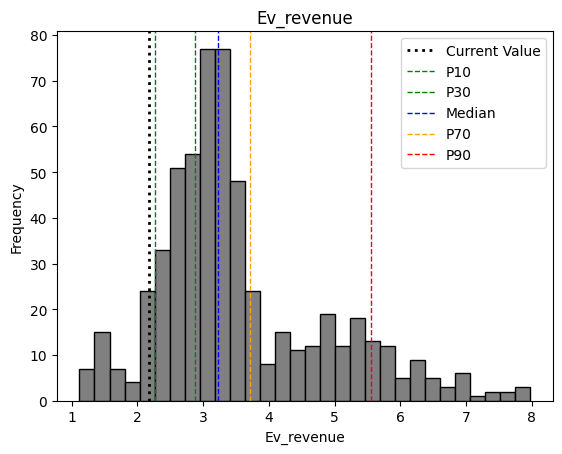

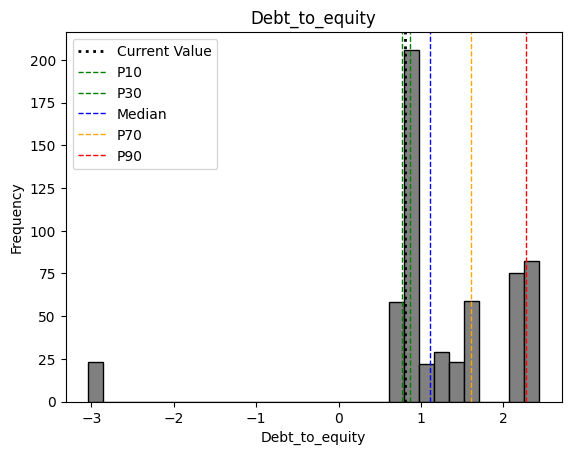

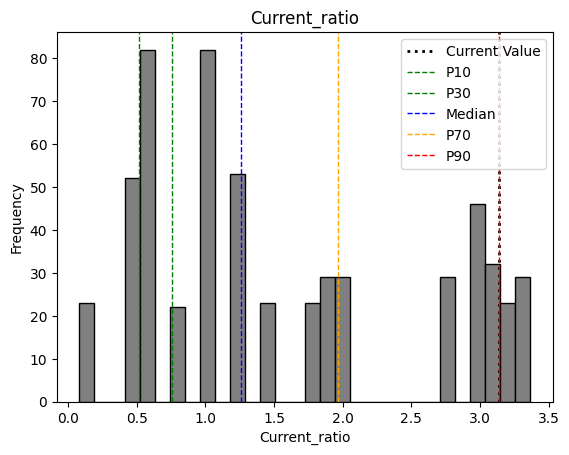

In [36]:
# plot histograms of value parameters
utils.plot_histogram_value_parameters(input_df=merged_nat_curr, extra_parameters=[])

## Calculate correlation between value parameters

In [37]:
# calulate value parameters Pearson's correlation coefficient
pd.DataFrame(merged_nat_curr, columns=['roa', 'roe', 'pe_ratio', 'pb_ratio', 'ps_ratio', 'ev_revenue', 'debt_to_equity', 'current_ratio']).corr()

,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,debt_to_equity,current_ratio
roa,1.000000,0.966370,-0.109754,0.349458,0.322587,0.141676,-0.302058,0.558400
roe,0.966370,1.000000,-0.067429,0.445603,0.380838,0.182303,-0.188489,0.525125
pe_ratio,-0.109754,-0.067429,1.000000,0.100787,0.003255,-0.062615,-0.046052,-0.179791
pb_ratio,0.349458,0.445603,0.100787,1.000000,0.906417,0.821978,0.309177,0.172098
ps_ratio,0.322587,0.380838,0.003255,0.906417,1.000000,0.953327,0.104981,0.128437
ev_revenue,0.141676,0.182303,-0.062615,0.821978,0.953327,1.000000,0.081362,-0.026388
debt_to_equity,-0.302058,-0.188489,-0.046052,0.309177,0.104981,0.081362,1.000000,0.079321
current_ratio,0.558400,0.525125,-0.179791,0.172098,0.128437,-0.026388,0.079321,1.000000


32 timestemos have been found!


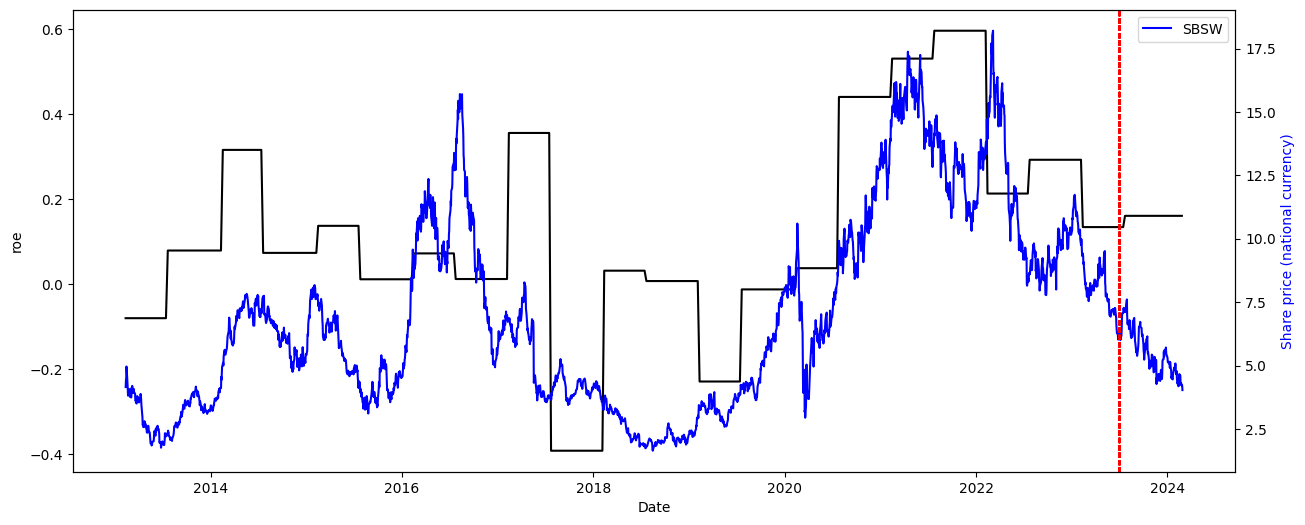

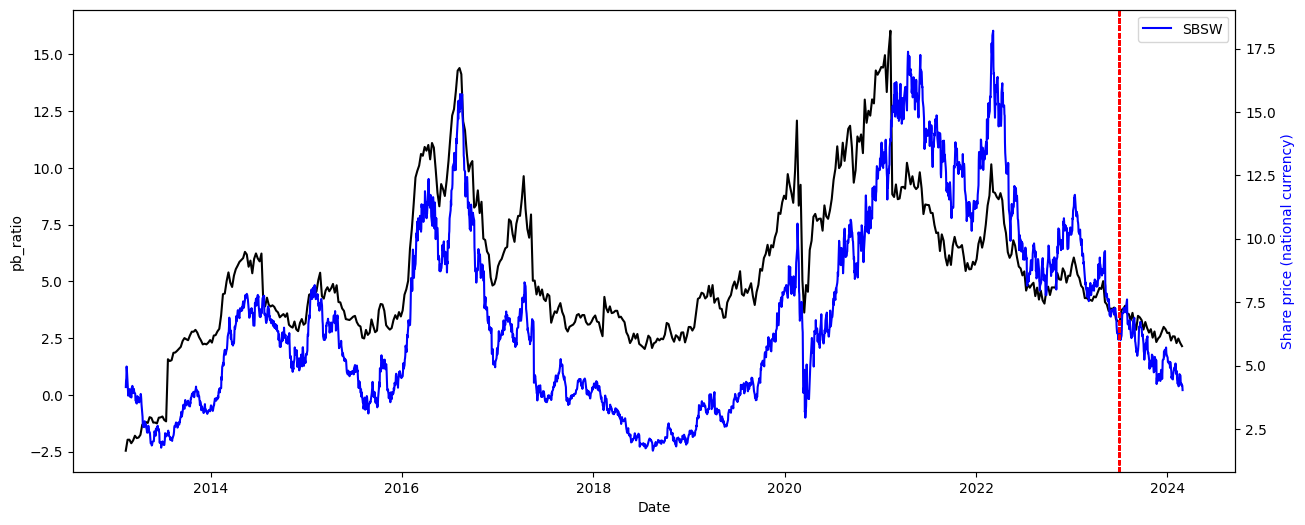

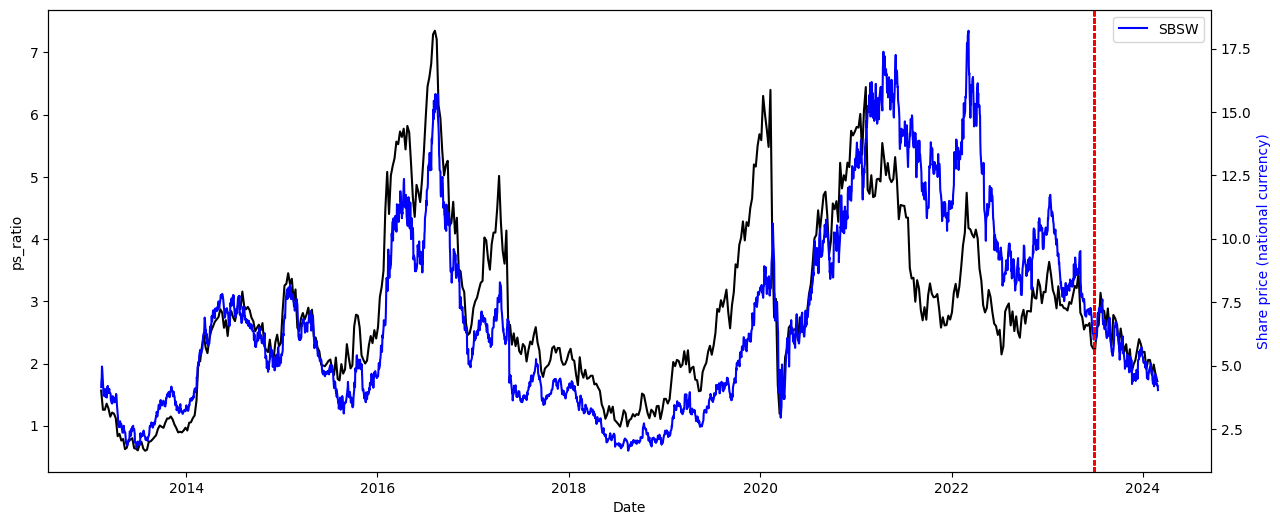

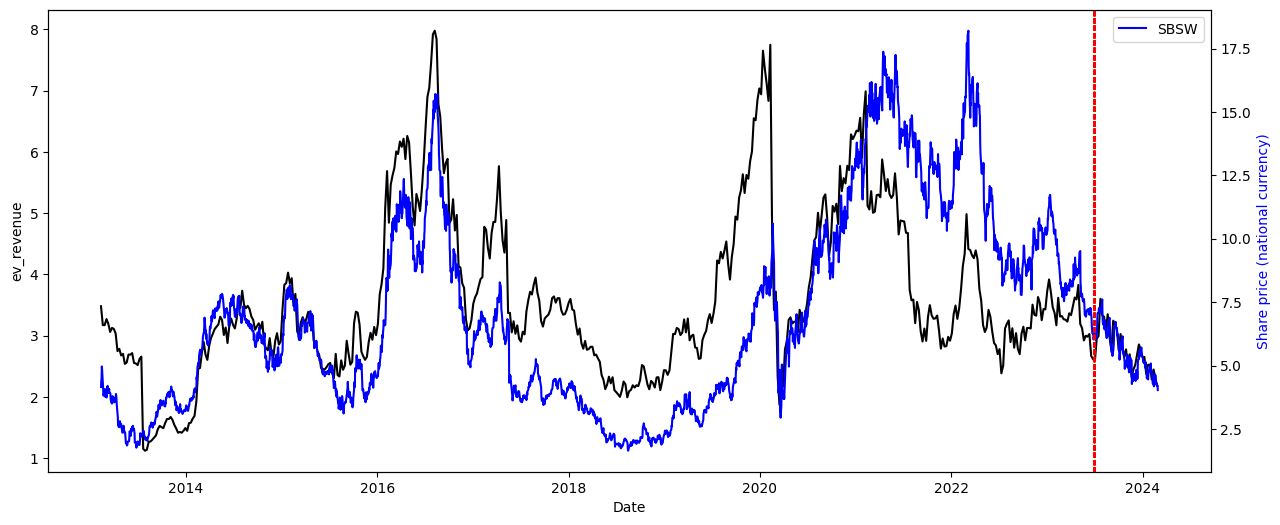

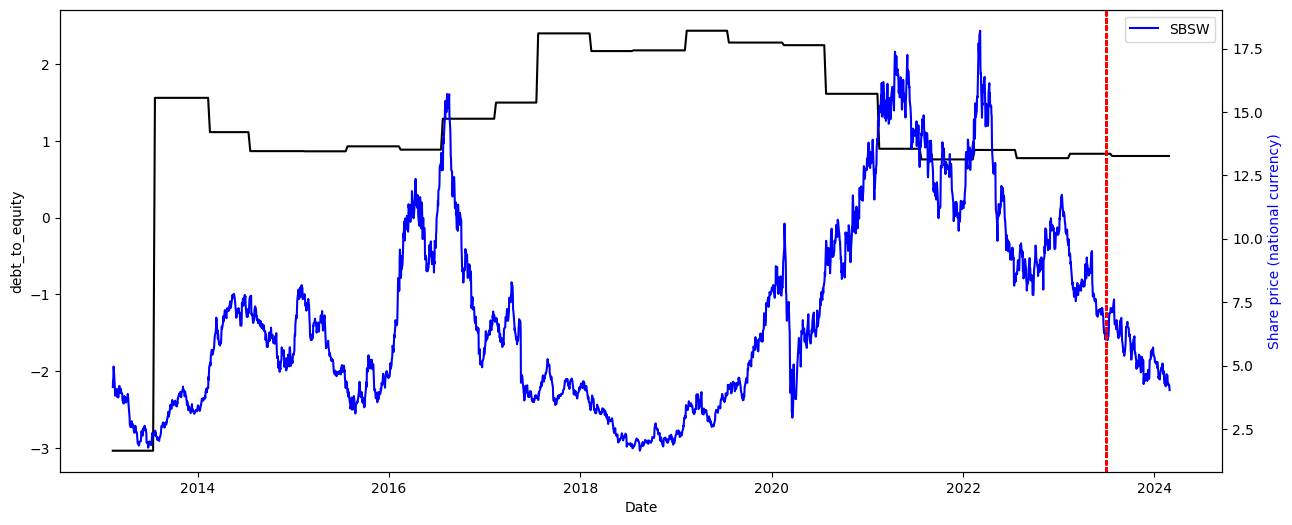

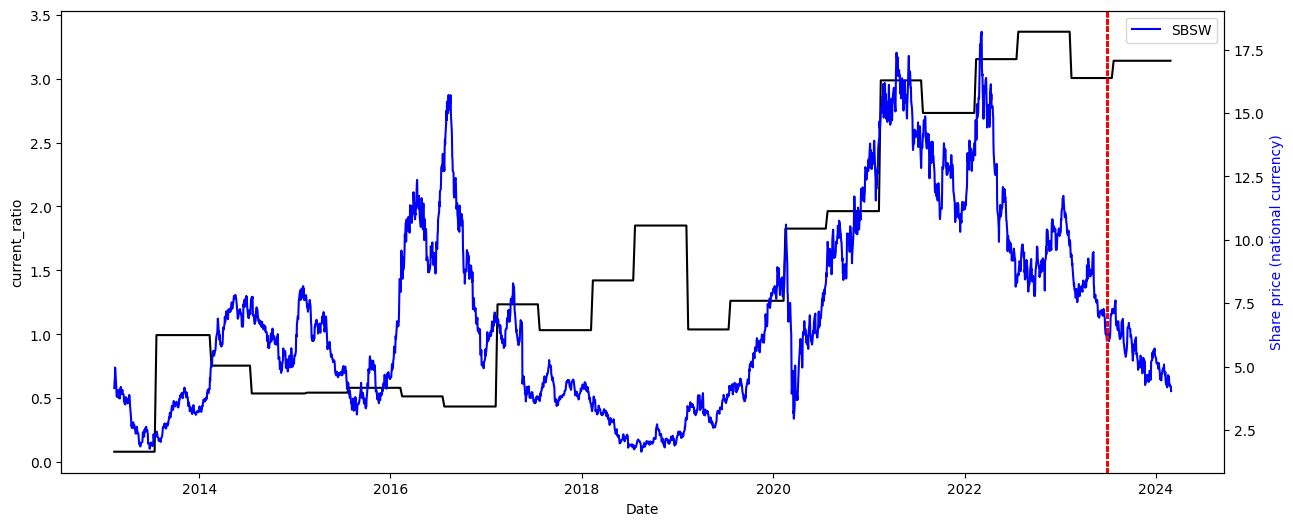

In [38]:
# plot value parameters in time and identify similar events
utils.get_historical_analouges(
    input_df=merged_nat_curr,
    ticker_all_price=ticker_all_price,
    share_name=share_name,
    tolerance=0.2
    )